In [9]:
!pip install scorecardpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-cp37-none-any.whl size=57826 sha256=74314ba2a3021b8f25da0ee344f0cb09f4296c6c92a2261be4a057bedd1e642f
  Stored in directory: /root/.cache/pip/wheels/1d/66/14/23aeb4e1128278f5880580e2fdd10e956de112a5d56a3a043e
Successfully built scorecardpy


In [4]:

#importing data
dataset = pd.read_excel('GermanCreditData(1).xlsx', sheet_name='Sheet1')
#dropped columns for bad, no need for it
dataset=dataset.drop(dataset.columns[[19]],axis=1)
dataset['Purpose']= dataset['Purpose'].replace(['X'],'10')

In [5]:
##Cleaning data
#check if any value is NaN
dataset.isnull().values.any()
#dropping the NaN values
dataset= dataset.dropna()

#chechking if there are empty spaces in dataset
if dataset.empty == True:
    print('empty spaces in dataframe')
else:
    print('no empty spaces in dataframe')

no empty spaces in dataframe


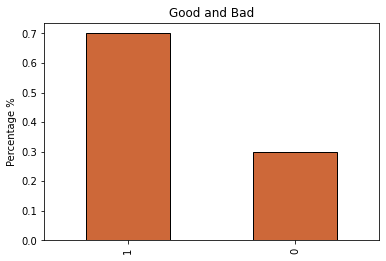

In [6]:
ll=['Good']
for x in ll:
    dataset[x].value_counts(normalize=True).plot(kind='bar',color='#CD6839',edgecolor='black')
    plt.title((('Good and Bad')))
    plt.ylabel('Percentage %')
    plt.show()

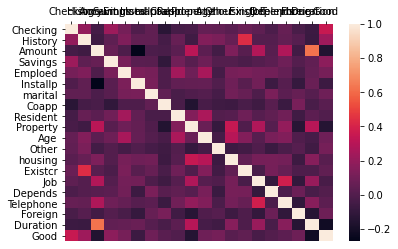

In [7]:
#correlation heatmap
"""
shows the correlation coefficient for each pair of variables.
"""
corrmat = dataset.corr()
corrmat
sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

In [10]:
#subsets
import scorecardpy as sc
dataset1 = dataset[dataset['Checking'] <=2 ]
dataset4 = dataset[dataset['Checking'] >2 ]
#finding the most important features using information value
feature_importance = sc.iv(dataset1, y="Good")
feature_importance = sc.iv(dataset4, y="Good")
#making the dataset with only the 4 most important variables
data1_act = dataset1[['Age','History','Duration','Property','Good']]
data4_act = dataset4[['Age','Other','Emploed','Purpose','Good']]
#data1_act.Purpose=data1_act.Purpose.astype(int)
data4_act.Purpose=data4_act.Purpose.astype(int)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
#list of datasets for function input
datasetss=[data1_act,data4_act]
def scores(dataa,oversampling):   
    """ 
    input oversampling=1 if you want to use SMOTE for oversampling
    """
    
    #scorecard building 
    import scorecardpy as sc
    

    datas = sc.var_filter(dataa, y="Good")
    
    #train and test (70%/30%)
    train1, test1 = sc.split_df(datas, 'Good').values()
    
    #woe bining
    num_bins = sc.woebin(datas, y="Good")
    sc.woebin_plot(num_bins)
    
    #binning adjustment
    change_breaks = sc.woebin_adj(datas, "Good", num_bins)

    bins_ch = sc.woebin(datas, y="Good", breaks_list=change_breaks)
    
    #change train and test to woe value
    trainwoe1 = sc.woebin_ply(train1, bins_ch )
    testwoe1 = sc.woebin_ply(test1, bins_ch )
    
    y_train = trainwoe1.loc[:,'Good']
    X_train = trainwoe1.loc[:,trainwoe1.columns != 'Good']
    y_test = testwoe1.loc[:,'Good']
    X_test = testwoe1.loc[:,trainwoe1.columns != 'Good']
    
    if oversampling==1:
        from imblearn.combine import SMOTETomek
        smk = SMOTETomek(random_state=0)
        #if i want to check the difference with SMOTE oversampling
        X_train, y_train= smk.fit_sample(X_train,y_train)

    #logisticRegression
    from sklearn.linear_model import LogisticRegression
    loggr = LogisticRegression(penalty='l1', C=10, solver='saga', n_jobs=-1)
    loggr.fit(X_train, y_train)
    loggr.coef_
    
    #predicted probability
    trainpred1 = loggr.predict_proba(X_train)[:,1]
    testpred1 = loggr.predict_proba(X_test)[:,1]
    
    #KS and ROC
    trainperf = sc.perf_eva(y_train, trainpred1, title = "train_set")
    testperf = sc.perf_eva(y_test, testpred1, title = "test_set")
    
    #scor
    final_card = sc.scorecard(bins_ch, loggr, X_train.columns)
    #credit_score
    trainscore = sc.scorecard_ply(train1, final_card, print_step=0)
    testscore = sc.scorecard_ply(test1, final_card, print_step=0)
    
    
    #confusion matrix
    from sklearn.metrics import classification_report
    cm1=[]
    evaluation=[]
    clre=[]
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix, accuracy_score
    y_pred = loggr.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    aa=pd.DataFrame(zip(X_train.columns, np.transpose(loggr.coef_.tolist()[0])), columns=['features', 'coef'])
    print(cm)
    cm1.append(cm)
    #accuracy score
    accuracy_score(y_test, y_pred)
    evaluation.append(accuracy_score(y_test, y_pred))
    #classification report
    cr = classification_report(y_test, y_pred)
    print(cr)
    clre.append(cr)
    return(clre,evaluation,cm,loggr.coef_, trainperf,testperf,final_card,trainscore, testscore,aa)



In [12]:
def scoreslinear(dataa):
    
    datas = sc.var_filter(dataa, y="Good")
    
    #train and test set
    train1, test1 = sc.split_df(datas, 'Good').values()
    
    #woe bining
    num_bins = sc.woebin(datas, y="Good")
    sc.woebin_plot(num_bins)   

    #changing bins
    changebreaks = sc.woebin_adj(datas, "Good", num_bins)

    bins_ch = sc.woebin(datas, y="Good", breaks_list=changebreaks)
    
    #change train and test into woe values
    trainwoe1 = sc.woebin_ply(train1, bins_ch )
    testwoe1 = sc.woebin_ply(test1, bins_ch )
    
    
    y_train = trainwoe1.loc[:,'Good']
    X_train = trainwoe1.loc[:,trainwoe1.columns != 'Good']
    y_test = testwoe1.loc[:,'Good']
    X_test = testwoe1.loc[:,trainwoe1.columns != 'Good']    


    
    
    ######################################Linear Regression
    from sklearn.linear_model import LinearRegression
    lr2 = LinearRegression()
    lr2.fit(X_train, y_train)
    lr2.coef_  
    
    y_pred2 = lr2.predict(X_test)
    
    #predicted probability
    train_pred2 = lr2.predict(X_train)
    test_pred2 = y_pred2
    
    #KS and ROC 
    trainperf2 = sc.perf_eva(y_train, train_pred2, title = "train_set")
    testperf2 = sc.perf_eva(y_test, test_pred2, title = "test_set")
    
    
    
    #making the outcome binary
    y_pred2_bi = []
    for x in y_pred2:
        if x >=0.5:
            y_pred2_bi.append(1)
        else:
            y_pred2_bi.append(0)
    y_pred2_bi= np.array(y_pred2_bi)
    
    #confusion matrix and accuracy score
    from sklearn.metrics import classification_report
    cm2=[]
    evaluation2=[]
    clre2=[]
    from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(y_test, y_pred2_bi)
    print(cm)
    cm2.append(cm)
    #accuracy score
    accuracy_score(y_test, y_pred2_bi)
    evaluation2.append(accuracy_score(y_test,y_pred2_bi))
    #classification report
    cr = classification_report(y_test, y_pred2_bi)
    print(cr)
    clre2.append(cr)   

    
    return(clre2,evaluation2,cm2,lr2.coef_, trainperf2,testperf2)

[INFO] filtering variables ...
[INFO] creating woe binning ...
-------- 1/4 Age --------
>>> dt[Age].describe(): 
count    543.000000
mean      34.716390
std       11.571718
min       19.000000
25%       26.000000
50%       31.000000
75%       40.000000
max       75.000000
Name: Age, dtype: float64 



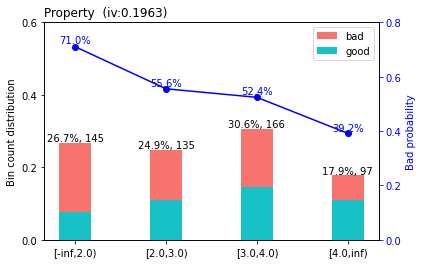

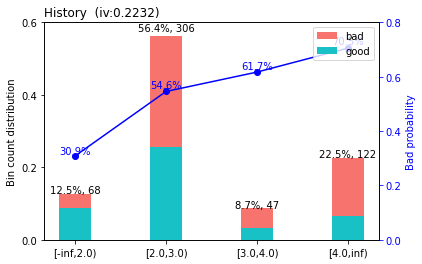

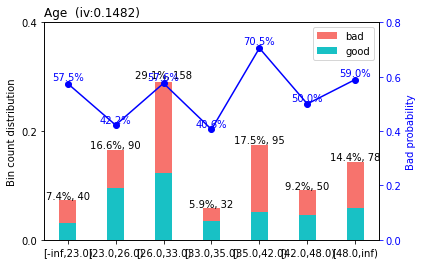

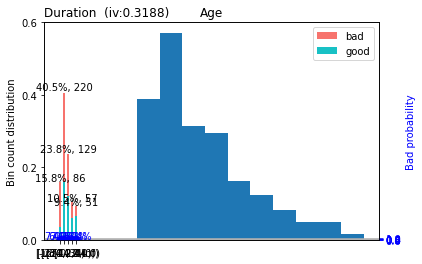

>>> Current breaks:
23.0,26.0,33.0,35.0,42.0,48.0 



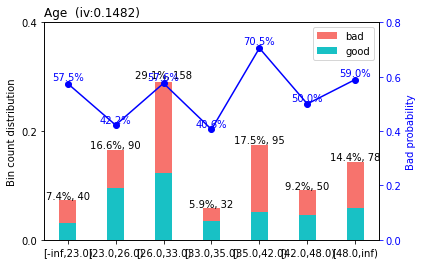

>>> Adjust breaks for (1/4) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/4 Duration --------
>>> dt[Duration].describe(): 
count    543.000000
mean      22.003683
std       12.710369
min        6.000000
25%       12.000000
50%       18.000000
75%       27.000000
max       72.000000
Name: Duration, dtype: float64 



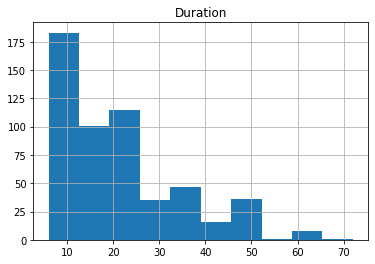

>>> Current breaks:
12.0,22.0,34.0,44.0 



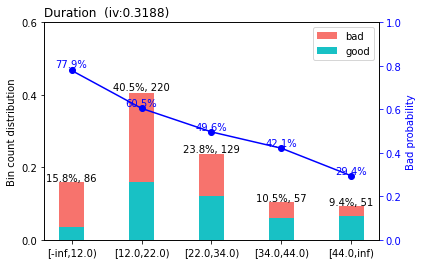

>>> Adjust breaks for (2/4) Duration?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/4 History --------
>>> dt[History].describe(): 
count    543.000000
mean       2.353591
std        1.076511
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: History, dtype: float64 

>>> dt[History].value_counts(): 
2    306
4    122
3     47
1     37
0     31
Name: History, dtype: int64 

>>> Current breaks:
2.0,3.0,4.0 



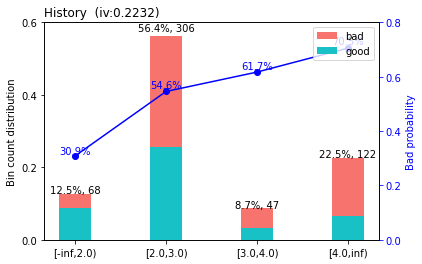

>>> Adjust breaks for (3/4) History?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/4 Property --------
>>> dt[Property].describe(): 
count    543.000000
mean       2.395948
std        1.064238
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Property, dtype: float64 

>>> dt[Property].value_counts(): 
3    166
1    145
2    135
4     97
Name: Property, dtype: int64 

>>> Current breaks:
2.0,3.0,4.0 



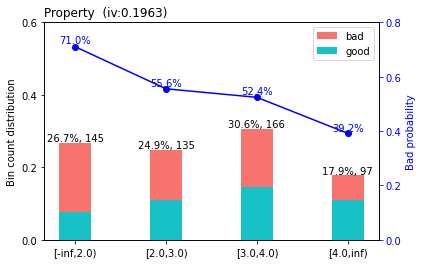

>>> Adjust breaks for (4/4) Property?
1: next 
2: yes 
3: back
Selection: 1
[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


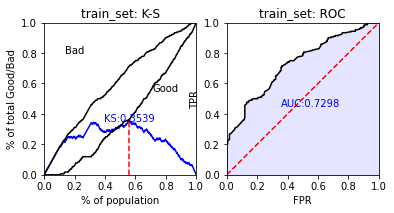

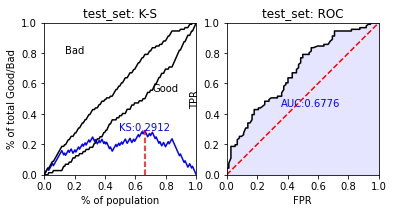

[[39 33]
 [28 63]]
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        72
           1       0.66      0.69      0.67        91

    accuracy                           0.63       163
   macro avg       0.62      0.62      0.62       163
weighted avg       0.62      0.63      0.62       163

[INFO] filtering variables ...
[INFO] creating woe binning ...
-------- 1/3 Age --------
>>> dt[Age].describe(): 
count    457.000000
mean      36.531729
std       11.069734
min       19.000000
25%       28.000000
50%       35.000000
75%       43.000000
max       74.000000
Name: Age, dtype: float64 



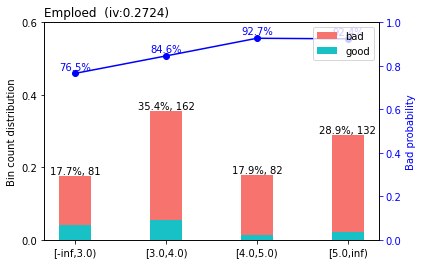

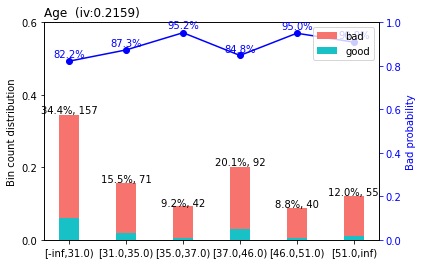

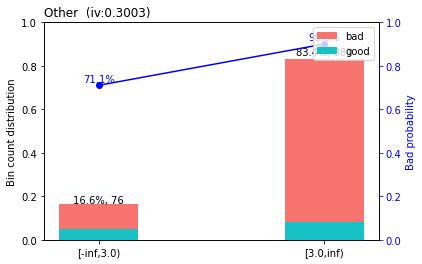

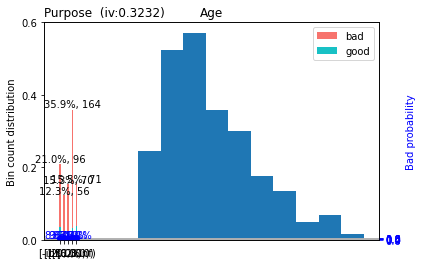

>>> Current breaks:
31.0,35.0,37.0,46.0,51.0 



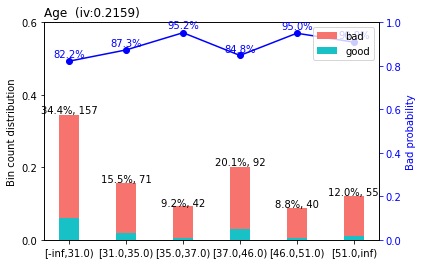

>>> Adjust breaks for (1/3) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/3 Emploed --------
>>> dt[Emploed].describe(): 
count    457.000000
mean       3.540481
std        1.158020
min        1.000000
25%        3.000000
50%        3.000000
75%        5.000000
max        5.000000
Name: Emploed, dtype: float64 

>>> dt[Emploed].value_counts(): 
3    162
5    132
4     82
2     63
1     18
Name: Emploed, dtype: int64 

>>> Current breaks:
3.0,4.0,5.0 



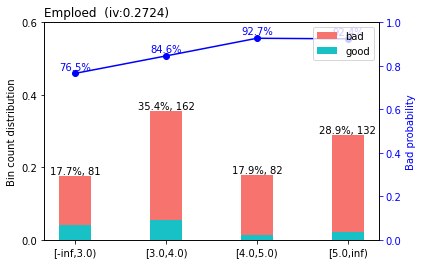

>>> Adjust breaks for (2/3) Emploed?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/3 Purpose --------
>>> dt[Purpose].describe(): 
count    457.000000
mean       2.785558
std        2.586650
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max       10.000000
Name: Purpose, dtype: float64 



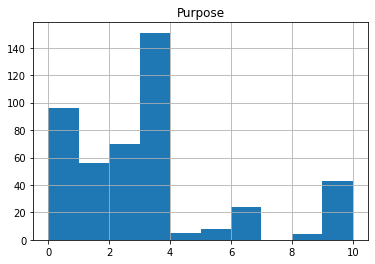

>>> Current breaks:
1.0,2.0,3.0,6.0 



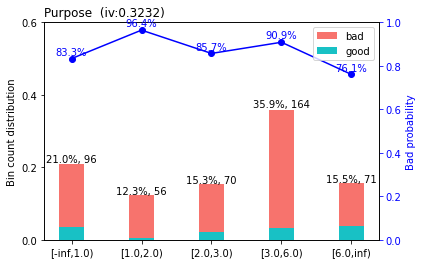

>>> Adjust breaks for (3/3) Purpose?
1: next 
2: yes 
3: back
Selection: 1
[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


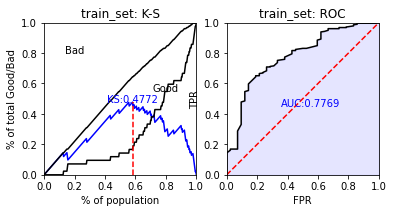

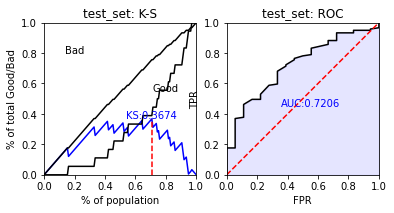

[[  1  17]
 [  5 114]]
              precision    recall  f1-score   support

           0       0.17      0.06      0.08        18
           1       0.87      0.96      0.91       119

    accuracy                           0.84       137
   macro avg       0.52      0.51      0.50       137
weighted avg       0.78      0.84      0.80       137

[INFO] filtering variables ...
[INFO] creating woe binning ...
-------- 1/4 Age --------
>>> dt[Age].describe(): 
count    543.000000
mean      34.716390
std       11.571718
min       19.000000
25%       26.000000
50%       31.000000
75%       40.000000
max       75.000000
Name: Age, dtype: float64 



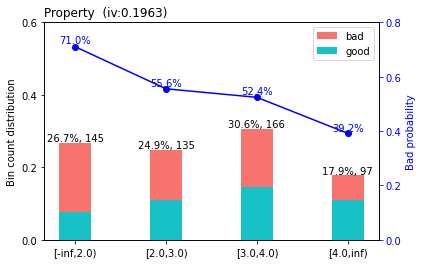

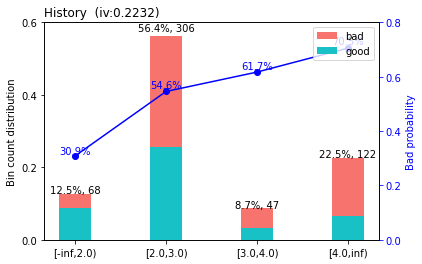

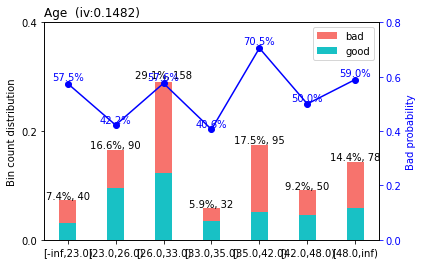

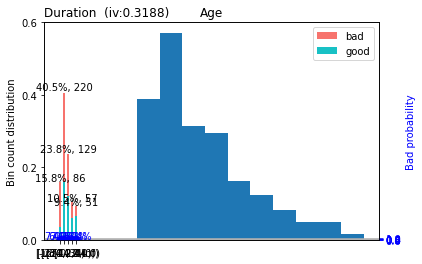

>>> Current breaks:
23.0,26.0,33.0,35.0,42.0,48.0 



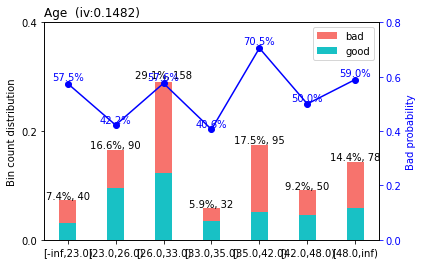

>>> Adjust breaks for (1/4) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/4 Duration --------
>>> dt[Duration].describe(): 
count    543.000000
mean      22.003683
std       12.710369
min        6.000000
25%       12.000000
50%       18.000000
75%       27.000000
max       72.000000
Name: Duration, dtype: float64 



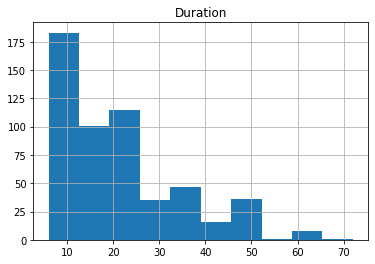

>>> Current breaks:
12.0,22.0,34.0,44.0 



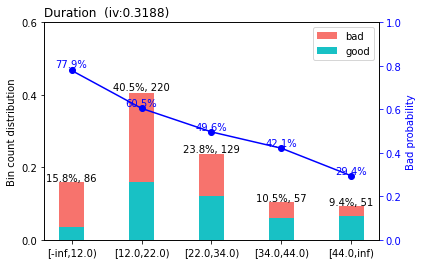

>>> Adjust breaks for (2/4) Duration?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/4 History --------
>>> dt[History].describe(): 
count    543.000000
mean       2.353591
std        1.076511
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: History, dtype: float64 

>>> dt[History].value_counts(): 
2    306
4    122
3     47
1     37
0     31
Name: History, dtype: int64 

>>> Current breaks:
2.0,3.0,4.0 



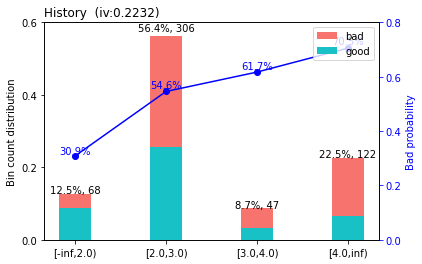

>>> Adjust breaks for (3/4) History?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/4 Property --------
>>> dt[Property].describe(): 
count    543.000000
mean       2.395948
std        1.064238
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Property, dtype: float64 

>>> dt[Property].value_counts(): 
3    166
1    145
2    135
4     97
Name: Property, dtype: int64 

>>> Current breaks:
2.0,3.0,4.0 



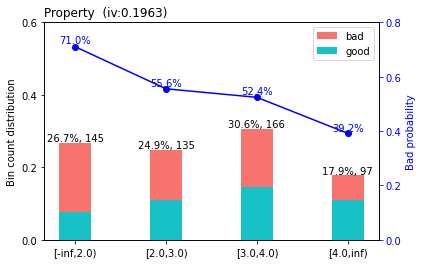

>>> Adjust breaks for (4/4) Property?
1: next 
2: yes 
3: back
Selection: 1
[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


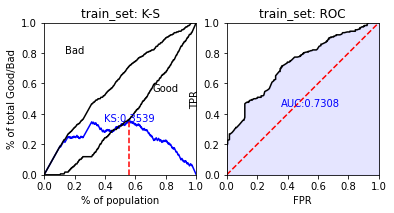

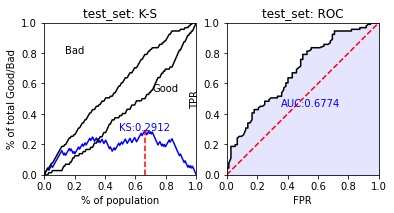

[[39 33]
 [28 63]]
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        72
           1       0.66      0.69      0.67        91

    accuracy                           0.63       163
   macro avg       0.62      0.62      0.62       163
weighted avg       0.62      0.63      0.62       163

[INFO] filtering variables ...
[INFO] creating woe binning ...
-------- 1/3 Age --------
>>> dt[Age].describe(): 
count    457.000000
mean      36.531729
std       11.069734
min       19.000000
25%       28.000000
50%       35.000000
75%       43.000000
max       74.000000
Name: Age, dtype: float64 



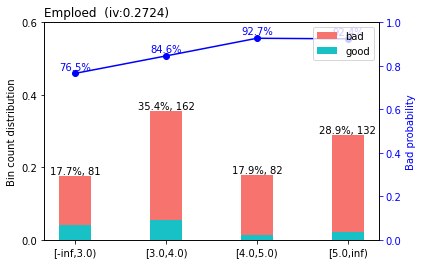

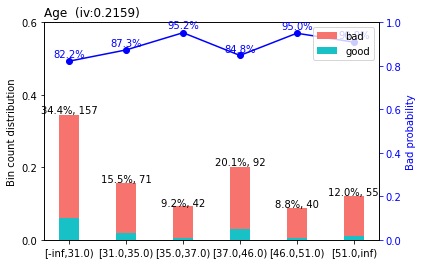

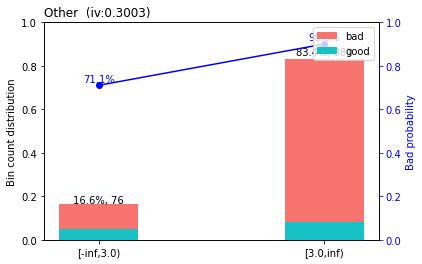

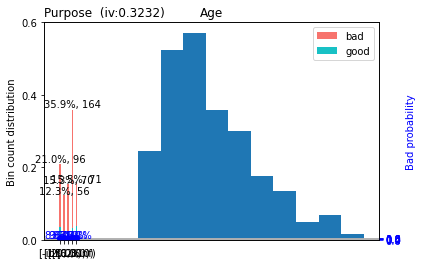

>>> Current breaks:
31.0,35.0,37.0,46.0,51.0 



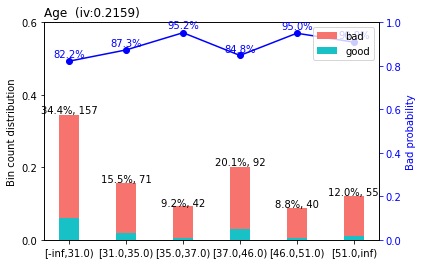

>>> Adjust breaks for (1/3) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/3 Emploed --------
>>> dt[Emploed].describe(): 
count    457.000000
mean       3.540481
std        1.158020
min        1.000000
25%        3.000000
50%        3.000000
75%        5.000000
max        5.000000
Name: Emploed, dtype: float64 

>>> dt[Emploed].value_counts(): 
3    162
5    132
4     82
2     63
1     18
Name: Emploed, dtype: int64 

>>> Current breaks:
3.0,4.0,5.0 



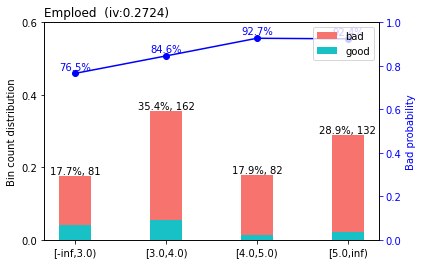

>>> Adjust breaks for (2/3) Emploed?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/3 Purpose --------
>>> dt[Purpose].describe(): 
count    457.000000
mean       2.785558
std        2.586650
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max       10.000000
Name: Purpose, dtype: float64 



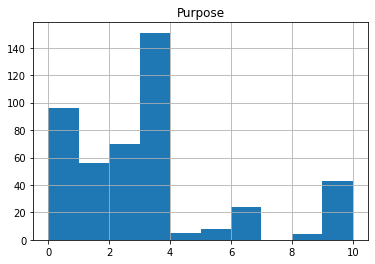

>>> Current breaks:
1.0,2.0,3.0,6.0 



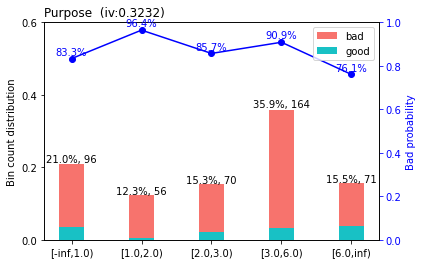

>>> Adjust breaks for (3/3) Purpose?
1: next 
2: yes 
3: back
Selection: 1
[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


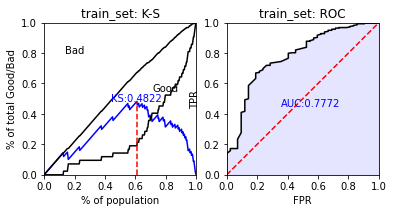

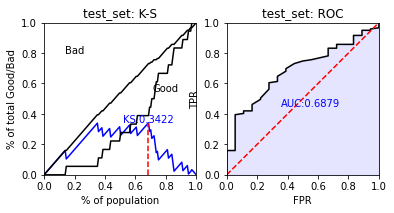

[[  0  18]
 [  0 119]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.87      1.00      0.93       119

    accuracy                           0.87       137
   macro avg       0.43      0.50      0.46       137
weighted avg       0.75      0.87      0.81       137



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#calls the functions above
logreg=scores(data1_act,0)
logreg4=scores(data4_act,0)
sss=scoreslinear(data1_act)
sss4=scoreslinear(data4_act)